In [5]:
#import all packages 
import pandas as pd
import warnings
import statsmodels.api as sm
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv('../data/kc_house_data.csv')

In [6]:
data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777
yr_renovated,-0.012010,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852


In [7]:
# drop columns that have no desire to our stakeholder 
clean_null = data.drop(columns=['id','date','long','yr_built','condition','view', 'waterfront',], axis=1)


In [8]:
clean_null.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_renovated,zipcode,lat,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,83.636778,98077.951845,47.560093,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,399.946414,53.513072,0.138552,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,0.000000,98001.000000,47.155900,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,0.000000,98033.000000,47.471100,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,0.000000,98065.000000,47.571800,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,0.000000,98118.000000,47.678000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,98199.000000,47.777600,6210.000000,871200.000000


In [65]:
# locating outliers in bedroom 
clean_null = clean_null.loc[clean_null['bedrooms'] < 8]
clean_null = clean_null.loc[clean_null['bathrooms'] < 6]
clean_null = clean_null.loc[clean_null['sqft_living'] < 6000 ]
clean_null = clean_null.loc[clean_null['price'] < 1500000 ]
clean_null = clean_null.loc[clean_null['bedrooms'] > .99]
clean_null = clean_null.loc[clean_null['bathrooms'] > .99]
clean_null = clean_null.loc[clean_null['sqft_living'] > 600 ]
clean_null = clean_null.loc[clean_null['price'] > 100000 ]
clean_null = clean_null.loc[clean_null['sqft_lot'] < 100000 ]
clean_null = clean_null.loc[clean_null['floors'] < 2.1 ]



In [10]:
clean_null = clean_null.loc[clean_null['sqft_basement'] != '?' ] 

In [11]:
clean_null['sqft_basement'] = clean_null['sqft_basement'].astype(float)

In [12]:
clean_null['true_sqft'] = clean_null['sqft_living']  - clean_null['sqft_basement']


In [13]:
# creating a new feature of price per sqft
clean_null['price_per_sqft'] = clean_null['price']  / clean_null['true_sqft']


In [14]:
test = [i[0:2].strip() for i in clean_null['grade']]


In [15]:
clean_null['grade_ordinal'] = [int(i[0:2].strip()) for i in clean_null['grade']]

In [16]:
zip_home_size = clean_null.loc[clean_null['zipcode'].isin([98052,98102,98103,98105,98109,98119,98121,98134,98164])]



In [17]:
curated_zip = np.array([98052,98102,98103,98105,98109,98119,98121,98134,98164])

In [18]:

# TODO add these OHE'd columns to main data by assigning <dfname>['zipcodes_ohe']
#
# take out the isin function for all zipcodes, if that makes the OLS work. could also narrow down to curated after the OHE on all zipcodes
zips = clean_null.loc[clean_null['zipcode'].isin(curated_zip)].dropna() 
ohe = OneHotEncoder(sparse=False, drop=[98109]) # the zip code with the highest prices in Seattle. could do 98052, near the Microsoft campus as well
ohe.fit(zips['zipcode'].to_numpy().reshape(-1, 1))
zips_encoded = ohe.transform(zips['zipcode'].to_numpy().reshape(-1, 1))

zipcodes_ohe = pd.DataFrame(zips_encoded, columns=ohe.get_feature_names(), index=zips.index)

In [19]:
zip_home_size.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode',
       'lat', 'sqft_living15', 'sqft_lot15', 'true_sqft', 'price_per_sqft',
       'grade_ordinal'],
      dtype='object')

In [20]:
zip_home_size.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_renovated,zipcode,lat,sqft_living15,sqft_lot15,true_sqft,price_per_sqft,grade_ordinal
price,1.000000,0.385248,0.455574,0.670996,0.118694,0.364769,0.571365,0.255721,0.095900,0.140795,-0.159207,0.484885,0.074767,0.571365,0.255037,0.593548
bedrooms,0.385248,1.000000,0.514230,0.638757,0.198276,0.237561,0.519254,0.287809,0.008931,-0.236354,0.080371,0.351513,0.171785,0.519254,-0.271004,0.283951
bathrooms,0.455574,0.514230,1.000000,0.703345,0.162710,0.484452,0.572887,0.314883,0.059175,-0.277840,0.075483,0.428102,0.162868,0.572887,-0.245165,0.576536
sqft_living,0.670996,0.638757,0.703345,1.000000,0.348899,0.425992,0.856676,0.371825,0.017210,-0.340077,0.170756,0.665886,0.337377,0.856676,-0.339494,0.661585
sqft_lot,0.118694,0.198276,0.162710,0.348899,1.000000,-0.045677,0.381533,-0.018984,-0.056516,-0.490942,0.323792,0.428761,0.872176,0.381533,-0.296214,0.295097
floors,0.364769,0.237561,0.484452,0.425992,-0.045677,1.000000,0.581161,-0.230711,0.033467,-0.064160,0.030006,0.320128,-0.051128,0.581161,-0.344749,0.521006
sqft_above,0.571365,0.519254,0.572887,0.856676,0.381533,0.581161,1.000000,-0.160336,-0.026687,-0.434793,0.261542,0.700724,0.378478,1.000000,-0.578028,0.700378
sqft_basement,0.255721,0.287809,0.314883,0.371825,-0.018984,-0.230711,-0.160336,1.000000,0.080943,0.131709,-0.143923,0.013156,-0.035533,-0.160336,0.390580,0.005550
yr_renovated,0.095900,0.008931,0.059175,0.017210,-0.056516,0.033467,-0.026687,0.080943,1.000000,0.125922,-0.052073,-0.061129,-0.053216,-0.026687,0.114789,0.006131
zipcode,0.140795,-0.236354,-0.277840,-0.340077,-0.490942,-0.064160,-0.434793,0.131709,0.125922,1.000000,-0.424472,-0.473659,-0.537077,-0.434793,0.617137,-0.312440


In [21]:
zip_new_columns = zip_home_size.drop(columns=['zipcode','grade','price_per_sqft','sqft_lot15','sqft_lot'], axis=1)
#zip_new_columns.reset_index(inplace=True, drop=True)


In [22]:
# concat two dataframes 
zip_ohe_columns = pd.concat([zip_new_columns , zipcodes_ohe], axis=1)
zip_ohe_columns

,price,bedrooms,bathrooms,sqft_living,floors,sqft_above,sqft_basement,yr_renovated,lat,sqft_living15,true_sqft,grade_ordinal,x0_98052,x0_98102,x0_98103,x0_98105,x0_98119
17,485000.0,4,1.00,1600,1.5,1600,0.0,0.0,47.6648,1610,1600.0,7,0.0,0.0,1.0,0.0,0.0
26,937000.0,3,1.75,2450,2.0,1750,700.0,NaN,47.6386,1760,1750.0,8,NaN,NaN,NaN,NaN,NaN
29,719000.0,4,2.50,2570,2.0,2570,0.0,0.0,47.7073,2630,2570.0,8,1.0,0.0,0.0,0.0,0.0
36,550000.0,4,1.00,1660,1.0,930,730.0,0.0,47.6621,2160,930.0,5,1.0,0.0,0.0,0.0,0.0
43,685000.0,3,1.00,1570,2.0,1570,0.0,0.0,47.6413,1580,1570.0,7,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21499,942990.0,4,2.50,3570,2.0,3570,0.0,0.0,47.7046,3230,3570.0,9,1.0,0.0,0.0,0.0,0.0
21541,530000.0,3,2.50,1410,2.0,1140,270.0,NaN,47.6515,1720,1140.0,8,NaN,NaN,NaN,NaN,NaN
21550,710200.0,4,3.00,1670,2.0,1350,320.0,0.0,47.6397,1670,1350.0,8,0.0,0.0,0.0,0.0,0.0
21563,645000.0,3,3.25,1730,2.0,1320,410.0,0.0,47.6374,1710,1320.0,9,0.0,0.0,0.0,0.0,1.0


In [23]:
zip_ohe_columns = zip_ohe_columns.dropna()


In [50]:
#zip_ohe_columns = zip_ohe_columns.drop(columns=['x0_98102',
      # 'x0_98103', 'x0_98105', 'x0_98119'], axis=1)
#zip_new_columns.reset_index(inplace=True, drop=True)

In [51]:
zip_ohe_columns.corr()

,price,bedrooms,bathrooms,sqft_living,floors,sqft_above,sqft_basement,yr_renovated,lat,sqft_living15,true_sqft,grade_ordinal,x0_98052
price,1.000000,0.378722,0.469247,0.685325,0.357067,0.585763,0.264767,0.095900,-0.163165,0.493543,0.585763,0.606296,-0.108082
bedrooms,0.378722,1.000000,0.493623,0.624528,0.222276,0.499243,0.303293,0.008931,0.072792,0.350736,0.499243,0.285390,0.235234
bathrooms,0.469247,0.493623,1.000000,0.702778,0.480868,0.570925,0.324909,0.059175,0.068087,0.440105,0.570925,0.588613,0.296438
sqft_living,0.685325,0.624528,0.702778,1.000000,0.422347,0.857207,0.381879,0.017210,0.154860,0.668948,0.857207,0.672554,0.336784
floors,0.357067,0.222276,0.480868,0.422347,1.000000,0.579547,-0.229072,0.033467,0.032070,0.322013,0.579547,0.509747,0.076916
sqft_above,0.585763,0.499243,0.570925,0.857207,0.579547,1.000000,-0.148595,-0.026687,0.248689,0.702282,1.000000,0.711124,0.436367
sqft_basement,0.264767,0.303293,0.324909,0.381879,-0.229072,-0.148595,1.000000,0.080943,-0.148941,0.024202,-0.148595,0.015260,-0.136416
yr_renovated,0.095900,0.008931,0.059175,0.017210,0.033467,-0.026687,0.080943,1.000000,-0.052073,-0.061129,-0.026687,0.006131,-0.117832
lat,-0.163165,0.072792,0.068087,0.154860,0.032070,0.248689,-0.148941,-0.052073,1.000000,0.176397,0.248689,0.073714,0.373242
sqft_living15,0.493543,0.350736,0.440105,0.668948,0.322013,0.702282,0.024202,-0.061129,0.176397,1.000000,0.702282,0.643093,0.497986


In [52]:
zip_ohe_columns.columns


Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'sqft_above',
       'sqft_basement', 'yr_renovated', 'lat', 'sqft_living15', 'true_sqft',
       'grade_ordinal', 'x0_98052'],
      dtype='object')

In [53]:

y = zip_ohe_columns['price']
x = zip_ohe_columns['sqft_living']
X_c = sm.add_constant(x)


simple_model = sm.OLS(y, X_c)


simple_model_results = simple_model.fit()
print(simple_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     1040.
Date:                Thu, 27 Oct 2022   Prob (F-statistic):          6.90e-164
Time:                        10:07:09   Log-Likelihood:                -15803.
No. Observations:                1176   AIC:                         3.161e+04
Df Residuals:                    1174   BIC:                         3.162e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.577e+05   1.38e+04     18.720      

In [54]:
#reviewing coef and p value significants 
y = zip_ohe_columns['price']
X = zip_ohe_columns.drop(['price'], axis=1)





y = y.dropna()
X = X.dropna()

# len(y), len(X)
ols_kch = sm.OLS(y, sm.add_constant(X)).fit()
ols_kch.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     281.8
Date:                Thu, 27 Oct 2022   Prob (F-statistic):          1.21e-302
Time:                        10:07:11   Log-Likelihood:                -15453.
No. Observations:                1176   AIC:                         3.093e+04
Df Residuals:                    1165   BIC:                         3.098e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.604e+07   7.68e+06      8.600      0.000     5.1e+07    8.11e+07
bedrooms       4733.1537   5133.817      0.922      0.357   -5339.408    1.48e+04
bathrooms     -1393.0584   7897.437     -0.176      0.860   -1.69e+04    1.41e+04
sqft_living      88.7110      6.215     14.275      0.000      76.518     100.904
floors        -4.543e+04   1.17e+04     -3.897      0.000   -6.83e+04   -2.26e+04
sqft_above       46.1505      4.166     11.079      0.000      37.978      54.323
sqft_basement    42.5585      7.215      5.898      0.000      28.402      56.715
yr_renovated     22.8940      8.322      2.751      0.006       6.566      39.222
lat            -1.39e+06   1.61e+05     -8.632      0.000   -1.71e+06   -1.07e+06
sqft_living15    70.2003      9.790      7.170      0.000      50.991      89.409
true_sqft        46.1545      4.166     11.080      0.000      37.981      54.328
grade_ordinal  6.726e+04   5974.889     11.257      0.000    5.55e+04     7.9e+04
x0_98052      -2.098e+05   9759.349    -21.499      0.000   -2.29e+05   -1.91e+05
==============================================================================
Omnibus:                      147.096   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              543.711
Skew:                           0.565   Prob(JB):                    8.60e-119
Kurtosis:                       6.133   Cond. No.                     1.39e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.39e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [55]:
#identifying the lots we recommend the stakeholder purchase and build new multifamily homes. 

zip_lot_size = clean_null.loc[(clean_null['zipcode'].isin([98052,98102,98103,98105,98109,98119,98121,98134,98164]))
                              & (clean_null['sqft_lot'] >= 40000)]

zip_lot_size

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_renovated,zipcode,lat,sqft_living15,sqft_lot15,true_sqft,price_per_sqft,grade_ordinal
340,485000.0,4,1.75,2560,43995,2.0,7 Average,2560,0.0,0.0,98052,47.6945,2560,14764,2560.0,189.453125,7
2580,965000.0,4,2.50,4070,57587,2.0,10 Very Good,4070,0.0,0.0,98052,47.6908,3890,35960,4070.0,237.100737,10
2956,900000.0,4,2.50,3620,42580,2.0,10 Very Good,3620,0.0,0.0,98052,47.7204,2950,33167,3620.0,248.618785,10
3671,620000.0,3,2.25,2190,45738,1.0,8 Good,2190,0.0,0.0,98052,47.7108,2970,4496,2190.0,283.105023,8
3716,735000.0,6,2.75,3360,84506,1.0,7 Average,2040,1320.0,0.0,98052,47.7150,2190,43124,2040.0,360.294118,7
4470,1050000.0,3,4.00,4380,42769,2.0,11 Excellent,4380,0.0,0.0,98052,47.7167,3630,35425,4380.0,239.726027,11
5302,1120000.0,4,3.25,4750,62365,2.0,11 Excellent,4750,0.0,0.0,98052,47.7149,3300,31866,4750.0,235.789474,11
6024,822000.0,4,2.50,2683,40386,2.0,9 Better,2683,0.0,0.0,98052,47.6982,2683,34800,2683.0,306.373463,9
6578,550000.0,3,2.25,1980,40887,1.0,8 Good,1980,0.0,NaN,98052,47.6478,2460,35700,1980.0,277.777778,8
9829,830000.0,4,2.50,1850,50662,1.0,8 Good,1430,420.0,0.0,98052,47.6535,2090,10599,1430.0,580.419580,8


In [ ]:
x 1 scaled and not scaled (x)
b4 1hot and after 

In [67]:
#Linearity
X = zip_ohe_columns.drop(['price'], axis=1)
ss = StandardScaler().fit(X)

X_scaled = ss.transform(X)

In [57]:
X_c = sm.add_constant(X_scaled)
y = zip_ohe_columns['price']

In [73]:
model = sm.OLS(endog=y, exog=X_c).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     281.8
Date:                Thu, 27 Oct 2022   Prob (F-statistic):          1.21e-302
Time:                        10:15:52   Log-Likelihood:                -15453.
No. Observations:                1176   AIC:                         3.093e+04
Df Residuals:                    1165   BIC:                         3.098e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.733e+05   3607.578    186.624      0.000    6.66e+05     6.8e+05
x1          4459.5842   4837.090      0.922      0.357   -5030.798    1.39e+04
x2         -1032.4592   5853.151     -0.176      0.860   -1.25e+04    1.05e+04
x3           5.09e+04   2998.537     16.974      0.000     4.5e+04    5.68e+04
x4         -2.024e+04   5193.180     -3.897      0.000   -3.04e+04      -1e+04
x5          4.035e+04   2671.932     15.101      0.000    3.51e+04    4.56e+04
x6          2.532e+04   4003.389      6.326      0.000    1.75e+04    3.32e+04
x7          1.006e+04   3656.997      2.751      0.006    2885.073    1.72e+04
x8         -3.454e+04   4001.870     -8.632      0.000   -4.24e+04   -2.67e+04
x9          4.101e+04   5719.312      7.170      0.000    2.98e+04    5.22e+04
x10         4.035e+04   2671.932     15.101      0.000    3.51e+04    4.56e+04
x11         6.665e+04   5921.038     11.257      0.000     5.5e+04    7.83e+04
x12        -1.018e+05   4737.302    -21.499      0.000   -1.11e+05   -9.26e+04
==============================================================================
Omnibus:                      147.096   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              543.711
Skew:                           0.565   Prob(JB):                    8.60e-119
Kurtosis:                       6.133   Cond. No.                     1.31e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.75e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

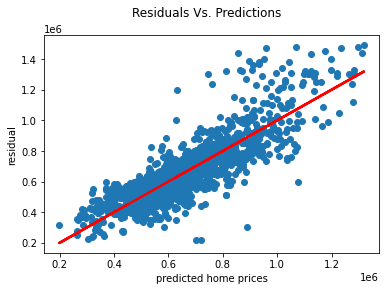

In [59]:
model_preds = model.predict(X_c)
resids = y - model_preds

fig, ax = plt.subplots()



ax.scatter(model_preds, y)
ax.set_xlabel('predicted home prices')
ax.set_ylabel('residual')
plt.suptitle('Residuals Vs. Predictions');


b, a = np.polyfit(model_preds, y, deg=1)


# Plot regression line
ax.plot(model_preds, a + b * model_preds, color="red", lw=2.5);


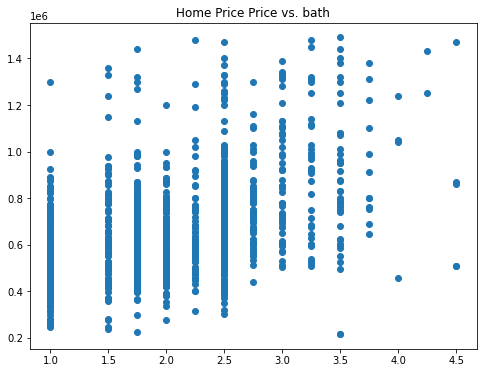

In [60]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 6))


ax.scatter(X['bathrooms'], y)
ax.set_title('Home Price Price vs. bath');

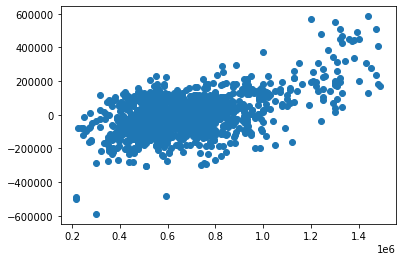

In [61]:
fig, ax = plt.subplots()

ax.scatter(y, resids);

In [62]:
dw = sm.stats.stattools.durbin_watson

In [63]:
dw(resids)

1.992541218331047

In [64]:
model.summary().tables[2]

Omnibus:,147.096,Durbin-Watson:,1.993
Prob(Omnibus):,0.000,Jarque-Bera (JB):,543.711
Skew:,0.565,Prob(JB):,8.60e-119
Kurtosis:,6.133,Cond. No.,1.31e+16


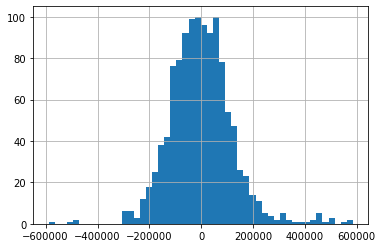

In [39]:
resids.hist(bins=50);

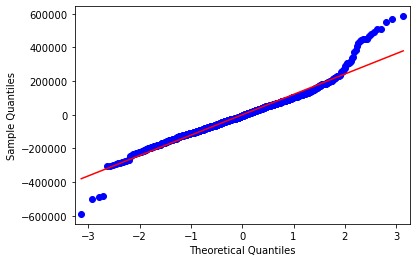

In [40]:
sm.qqplot(resids, line='r');

In [41]:
zip_ohe_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 17 to 21567
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          1176 non-null   float64
 1   bedrooms       1176 non-null   int64  
 2   bathrooms      1176 non-null   float64
 3   sqft_living    1176 non-null   int64  
 4   floors         1176 non-null   float64
 5   sqft_above     1176 non-null   int64  
 6   sqft_basement  1176 non-null   float64
 7   yr_renovated   1176 non-null   float64
 8   lat            1176 non-null   float64
 9   sqft_living15  1176 non-null   int64  
 10  true_sqft      1176 non-null   float64
 11  grade_ordinal  1176 non-null   int64  
 12  x0_98052       1176 non-null   float64
dtypes: float64(8), int64(5)
memory usage: 128.6 KB


In [42]:
zip_ohe_columns['grade_ordinal'].unique()

array([ 7,  8,  5,  9,  6, 11, 10, 12], dtype=int64)

ValueError: x and y must be the same size

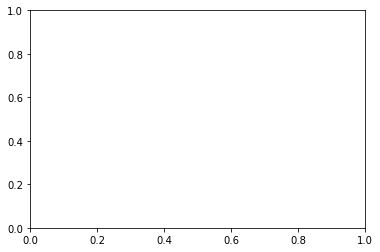

In [43]:
fig, ax = plt.subplots()

ax.scatter(y=zip_ohe_columns['price'], x=zip_ohe_columns.drop(['price'], axis=1));

In [ ]:
model.summary().tables[2]

In [ ]:
y.hist();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(y, resids);

In [ ]:
y_log = np.log(y)
y_log.hist();

In [ ]:
# 'x1' is 
sm.graphics.plot_regress_exog(model, 'x1', fig=plt.figure(figsize=(12, 8)));